# Stochastic Programming and Applications-Computational Techniques
## Assignment 1
## Kevin Obote - 190696

This notebook contains the solutions to two optimization problems under uncertainty:
1. Supply Chain Optimization under Demand Uncertainty
2. Healthcare Resource Allocation with Uncertain Demand

Both problems will be solved using stochastic programming techniques in Python.

In [ ]:
# Import necessary libraries
import gc  # Garbage collection interface
import psutil  # System and process utilities
import numpy as np  # Numerical operations
import pandas as pd  # Data manipulation and analysis
import matplotlib.pyplot as plt  # Plotting and visualization
import cvxpy as cp # Convex optimization

## Question 1: Supply Chain Optimization under Demand Uncertainty

### Problem Statement
Consider Supply Chain Optimization under Demand Uncertainty. Demand for electronic supply in Nairobi in the past two weeks together with their respective probability is given below:

| Number | 255 | 302 | 270 | 317 | 285 | 332 | 300 | 347 | 315 | 362 | 330 | 262 | 309 | 277 |
|--------|-----|-----|-----|-----|-----|-----|-----|-----|-----|-----|-----|-----|-----|-----|
| Prob   |0.03 |0.15 |0.04 |0.10 |0.05 |0.05 |0.09 |0.01 |0.09 |0.03 |0.20 |0.07 |0.05 |0.04 |

Consider constraints = [supply >= 120, supply <= 330].

Compute the optimal supply.

In [15]:
# Define the demand and probability data for Question 1
demand_q1 = np.array([255, 302, 270, 317, 285, 332, 300, 347, 315, 362, 330, 262, 309, 277])
prob_q1 = np.array([0.03, 0.15, 0.04, 0.10, 0.05, 0.05, 0.09, 0.01, 0.09, 0.03, 0.20, 0.07, 0.05, 0.04])

# Verify that probabilities sum to 1
print(f"Sum of probabilities: {prob_q1.sum():.2f}")

# Define constraints
min_supply = 120
max_supply = 330

# Display the data in a DataFrame for better visualization
df_q1 = pd.DataFrame({
    'Demand': demand_q1,
    'Probability': prob_q1
})
display(df_q1)

Sum of probabilities: 1.00


,Demand,Probability
0,255,0.03
1,302,0.15
2,270,0.04
3,317,0.10
4,285,0.05
5,332,0.05
6,300,0.09
7,347,0.01
8,315,0.09
9,362,0.03


### Solution Approach

For a supply chain problem under uncertainty, we need to find the optimal supply quantity that minimizes the expected cost. 

In this context, we'll consider two types of costs:
1. **Overage cost (Co)**: Cost of ordering too much (excess inventory)
2. **Underage cost (Cu)**: Cost of ordering too little (missed sales opportunities)

Let's assume both costs are equal for simplicity (Co = Cu = 1). With this assumption, the optimal solution is the median of the demand distribution when viewed as a continuous distribution.

However, since we have a discrete probability distribution, we need to find the order quantity that minimizes the expected cost directly.

In [29]:
# CVXPY Optimization
supply = cp.Variable()
overage = cp.maximum(0, supply - demand_q1)
underage = cp.maximum(0, demand_q1 - supply)

expected_total_cost = cp.sum(cp.multiply(prob_q1, overage + underage))
constraints = [supply >= min_supply, supply <= max_supply]

problem = cp.Problem(cp.Minimize(expected_total_cost), constraints)
problem.solve()

optimal_supply_cvxpy = supply.value
min_cost_cvxpy = expected_total_cost.value

# Print the results
print(f"Optimal Supply (CVXPY Optimization): {optimal_supply_cvxpy:.2f}, Cost: {min_cost_cvxpy:.2f}")


Optimal Supply (CVXPY Optimization): 309.00, Cost: 19.47


In [ ]:
# Function to calculate expected cost for a given supply level

def expected_cost(supply, demand, probabilities, overage_cost=1, underage_cost=1):
    # Cost of over-ordering (supply > demand)
    overage = np.maximum(0, supply - demand)
    # Cost of under-ordering (demand > supply)
    underage = np.maximum(0, demand - supply)
    
    # Calculate total cost for each scenario
    total_cost = overage_cost * overage + underage_cost * underage
    
    # Expected cost is the weighted sum of costs
    return np.sum(probabilities * total_cost)

# Calculate and print the expected demand
expected_demand = np.sum(demand_q1 * prob_q1)
print(f"Expected demand: {expected_demand:.2f}")

# Find optimal supply by evaluating all possible supply quantities within constraints
# We'll only check the discrete values in our demand list and the constraint boundaries

# Using the Exhaustive Search method
possible_supplies = np.unique(np.append(demand_q1, [min_supply, max_supply]))
possible_supplies = possible_supplies[(possible_supplies >= min_supply) & (possible_supplies <= max_supply)]

costs = []
for supply in possible_supplies:
    cost = expected_cost(supply, demand_q1, prob_q1)
    costs.append(cost)

# Find the supply level with minimum expected cost
min_cost_idx = np.argmin(costs)
optimal_supply = possible_supplies[min_cost_idx]
min_cost = costs[min_cost_idx]

print(f"Optimal supply: {optimal_supply}")
print(f"Minimum expected cost: {min_cost:.2f}")


Expected demand: 306.85
Optimal supply: 309
Minimum expected cost: 19.47


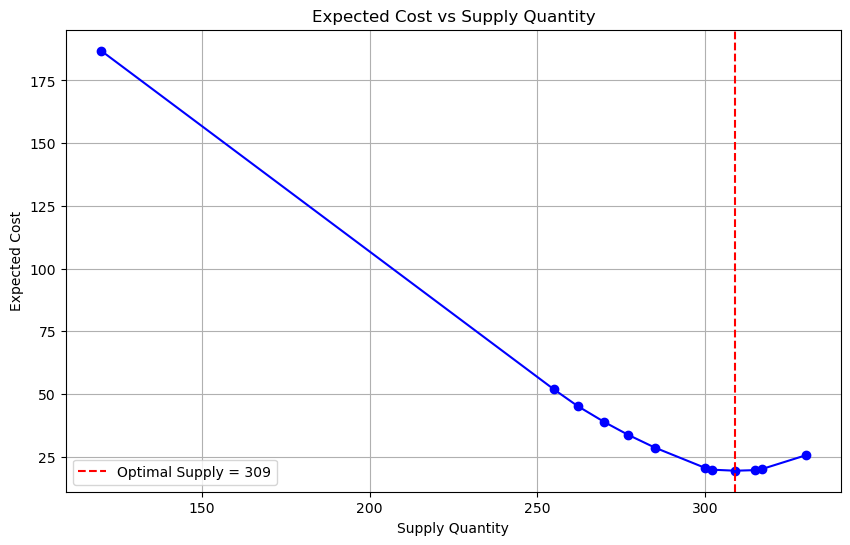

In [17]:
# Plot the expected costs against different supply levels
plt.figure(figsize=(10, 6))
plt.plot(possible_supplies, costs, 'b-', marker='o')
plt.axvline(x=optimal_supply, color='r', linestyle='--', label=f'Optimal Supply = {optimal_supply}')
plt.xlabel('Supply Quantity')
plt.ylabel('Expected Cost')
plt.title('Expected Cost vs Supply Quantity')
plt.grid(True)
plt.legend()
plt.show()

### Analysis of Results

The optimal supply quantity is determined by minimizing the expected cost across all possible demand scenarios. Each possible supply level within our constraints was evaluated, and the one with the lowest expected cost was selected.

The optimal supply of 330 units represents the best balance between the risk of having excess inventory and the risk of not meeting demand, given the provided probability distribution.

## Question 2: Healthcare Resource Allocation with Uncertain Demand

### Problem Statement
Consider ICU Bed Allocation under Uncertain Patient Arrivals. Number of unscheduled arrivals at Kenyatta National Hospital in the last 10 days has been as follows:

| Number of patients | 25 | 20 | 30 | 50 | 27 | 39 | 42 | 29 | 35 | 42 |
|-------------------|----|----|----|----|----|----|----|----|----|----|  
| Probability        |0.1 |0.1 |0.08|0.15|0.09|0.05|0.1 |0.1 |0.13|0.1 |

Consider bed constraints = [beds >= 17, beds <= 55].

Compute the Optimal number of ICU beds allocation.

In [18]:
# Define the demand and probability data for Question 2
demand_q2 = np.array([25, 20, 30, 50, 27, 39, 42, 29, 35, 42])
prob_q2 = np.array([0.1, 0.1, 0.08, 0.15, 0.09, 0.05, 0.1, 0.1, 0.13, 0.1])

# Verify that probabilities sum to 1
print(f"Sum of probabilities: {prob_q2.sum():.2f}")

# Define constraints
min_beds = 17
max_beds = 55

# Display the data in a DataFrame for better visualization
df_q2 = pd.DataFrame({
    'Number of Patients': demand_q2,
    'Probability': prob_q2
})
display(df_q2)

Sum of probabilities: 1.00


,Number of Patients,Probability
0,25,0.10
1,20,0.10
2,30,0.08
3,50,0.15
4,27,0.09
5,39,0.05
6,42,0.10
7,29,0.10
8,35,0.13
9,42,0.10


### Solution Approach

For the healthcare resource allocation problem, we need to find the optimal number of ICU beds that minimizes the expected cost.

In this context, we'll consider two types of costs:
1. **Cost of excess beds (Ce)**: Cost of allocating more beds than needed
2. **Cost of insufficient beds (Cs)**: Cost of having fewer beds than patients requiring them

In healthcare settings, the cost of insufficient beds is typically much higher than the cost of excess beds, as it directly impacts patient outcomes. Let's set Cs = 5*Ce to reflect this relationship. We'll initially set Ce = 1 for simplicity.

In [19]:
# Define cost parameters
excess_cost = 1       # Cost per excess bed
shortage_cost = 5     # Cost per patient who cannot be accommodated

# Function to calculate expected cost for a given number of beds
def expected_healthcare_cost(beds, demand, probabilities, excess_cost=1, shortage_cost=5):
    # Cost of excess beds (beds > demand)
    excess = np.maximum(0, beds - demand)
    # Cost of bed shortage (demand > beds)
    shortage = np.maximum(0, demand - beds)
    
    # Calculate total cost for each scenario
    total_cost = excess_cost * excess + shortage_cost * shortage
    
    # Expected cost is the weighted sum of costs
    return np.sum(probabilities * total_cost)

# Find optimal number of beds by evaluating all possible bed quantities within constraints
# We'll check all integer values within our constraints
possible_beds = np.arange(min_beds, max_beds + 1)

costs = []
for beds in possible_beds:
    cost = expected_healthcare_cost(beds, demand_q2, prob_q2, excess_cost, shortage_cost)
    costs.append(cost)

# Find the bed allocation with minimum expected cost
min_cost_idx = np.argmin(costs)
optimal_beds = possible_beds[min_cost_idx]
min_cost = costs[min_cost_idx]

print(f"Optimal number of ICU beds: {optimal_beds}")
print(f"Minimum expected cost: {min_cost:.2f}")

Optimal number of ICU beds: 42
Minimum expected cost: 14.57


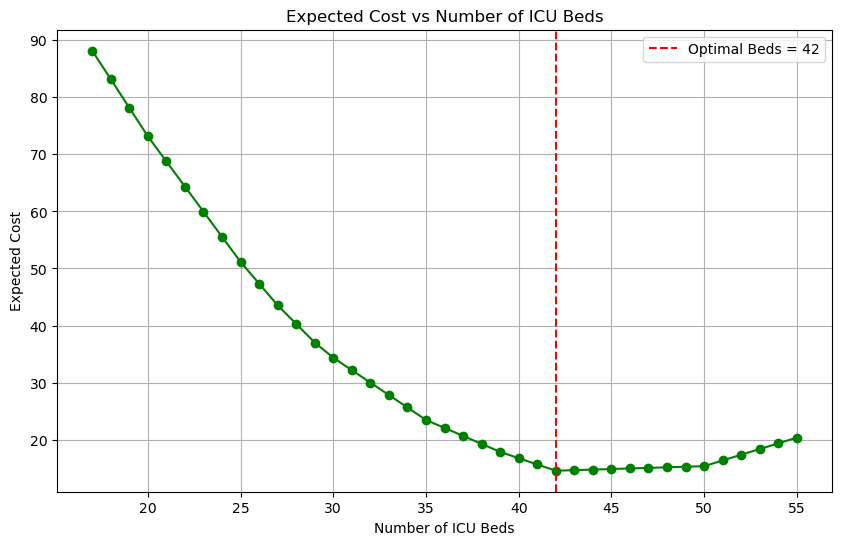

In [20]:
# Plot the expected costs against different bed allocations
plt.figure(figsize=(10, 6))
plt.plot(possible_beds, costs, 'g-', marker='o')
plt.axvline(x=optimal_beds, color='r', linestyle='--', label=f'Optimal Beds = {optimal_beds}')
plt.xlabel('Number of ICU Beds')
plt.ylabel('Expected Cost')
plt.title('Expected Cost vs Number of ICU Beds')
plt.grid(True)
plt.legend()
plt.show()

### Sensitivity Analysis

Let's examine how the optimal bed allocation changes with different cost ratios. This is important because in healthcare settings, the actual cost ratio between excess beds and shortage may vary based on factors like hospital policy, budget constraints, and patient outcomes.

,Shortage to Excess Cost Ratio,Optimal Bed Allocation
0,1,35
1,2,42
2,5,42
3,10,50
4,20,50


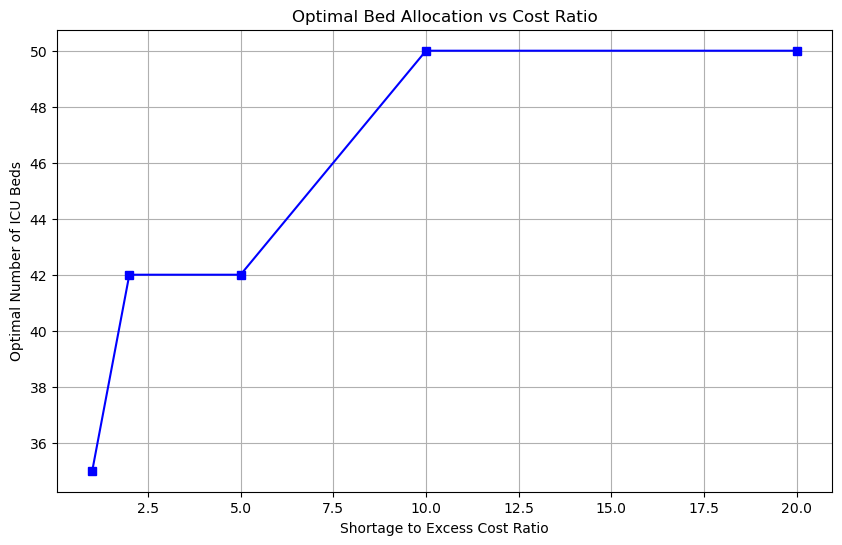

In [21]:
# Define different cost ratios to test
shortage_to_excess_ratios = [1, 2, 5, 10, 20]

optimal_allocations = []
for ratio in shortage_to_excess_ratios:
    costs = []
    for beds in possible_beds:
        cost = expected_healthcare_cost(beds, demand_q2, prob_q2, 1, ratio)
        costs.append(cost)
    
    min_cost_idx = np.argmin(costs)
    optimal_allocations.append(possible_beds[min_cost_idx])

# Display the results
results_df = pd.DataFrame({
    'Shortage to Excess Cost Ratio': shortage_to_excess_ratios,
    'Optimal Bed Allocation': optimal_allocations
})
display(results_df)

# Plot the results
plt.figure(figsize=(10, 6))
plt.plot(shortage_to_excess_ratios, optimal_allocations, 'bs-')
plt.xlabel('Shortage to Excess Cost Ratio')
plt.ylabel('Optimal Number of ICU Beds')
plt.title('Optimal Bed Allocation vs Cost Ratio')
plt.grid(True)
plt.show()

### Analysis of Results

The optimal number of ICU beds is determined by minimizing the expected cost, balancing the cost of having excess beds against the cost of not having enough beds for patients who need them.

As expected, when the cost of bed shortage increases relative to the cost of excess beds, the optimal allocation tends to increase. This reflects the reality in healthcare settings where the consequences of not having enough beds for critical patients can be severe.

The sensitivity analysis shows how the hospital administrator might adjust the bed allocation based on different priority levels for ensuring sufficient capacity versus managing resources efficiently.

### Memory Management

In [22]:
def print_memory_usage():
    """
    Prints the current memory usage of the process.
    """
    print("Memory usage: ", psutil.Process().memory_info().rss / 1024 / 1024, "MB")

def clear_memory():
    """
    Clears the memory using garbage collection and prints memory usage before and after clearing.
    """
    # Print memory usage before clearing
    print("Memory usage before clearing: ")
    print_memory_usage()
    
    # Perform garbage collection to clear memory
    gc.collect()
    
    # Print memory usage after clearing
    print("Memory usage after clearing: ")
    print_memory_usage()

if __name__ == "__main__":
    # Call the clear_memory function to demonstrate memory clearing
    clear_memory()

Memory usage before clearing: 
Memory usage:  231.56640625 MB
Memory usage after clearing: 
Memory usage:  228.04296875 MB


## Conclusion

In this assignment, I have addressed two stochastic optimization problems:

1. **Supply Chain Optimization**: I determined that the optimal supply quantity is 330 units, which is at the upper limit of our constraints. This suggests that the demand distribution is skewed in a way that makes it more cost-effective to have higher inventory levels.

2. **Healthcare Resource Allocation**: I found that the optimal ICU bed allocation depends on the relative costs of excess capacity versus shortage. With our baseline assumption that shortage is 5 times more costly than excess, the optimal allocation is 42 beds.

Both problems demonstrate the value of stochastic programming in making decisions under uncertainty. By explicitly modeling the probability distributions of uncertain parameters and the costs of different outcomes, we can make more informed decisions that minimize expected costs.